In [84]:
import gzip
import pickle

import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from adjustText import adjust_text

In [85]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [86]:
# Genes significantly associated with heart rate.
req = requests.get("https://exphewas.ca/v1/api/outcome/cont_v9/results")

In [87]:
hr_assoc = req.json()

In [88]:
# Keep genes with a very stringent FDR
hr_assoc_sig = [o for o in hr_assoc if o["q"] <= 5e-8]
len(hr_assoc_sig)

554

In [89]:
# MR effects (load from cache or query from website)
filename = "hr_afib_cis_MR_results.pkl.gz"
try:
    with gzip.open(filename, "rb") as f:
        mr_results = pickle.load(f)
except FileNotFoundError:
    mr_results = []
    for i, o in enumerate(hr_assoc_sig):
        url = (
            "https://exphewas.ca/v1/api/cisMR?"
            "exposure_id=cont_v9&"
            "exposure_type=CONTINUOUS_VARIABLE&"
            "outcome_id=427.2&"
            "outcome_type=PHECODES&"
            "ensembl_id={gene}"
        )
        req = requests.get(url.format(gene=o["gene"]))
        res = req.json()
        res["gene"] = o["gene"]
        mr_results.append(res)
        
    # Serialize because it takes a while to get the results
    with gzip.open(filename, "wb") as f:
        pickle.dump(mr_results, f)

In [90]:
points_to_label = sorted(mr_results, key=lambda o: o["wald_p"])[:20]
for o in mr_results:
    o["wald_nlog10p"] = -np.log10(o["wald_p"])

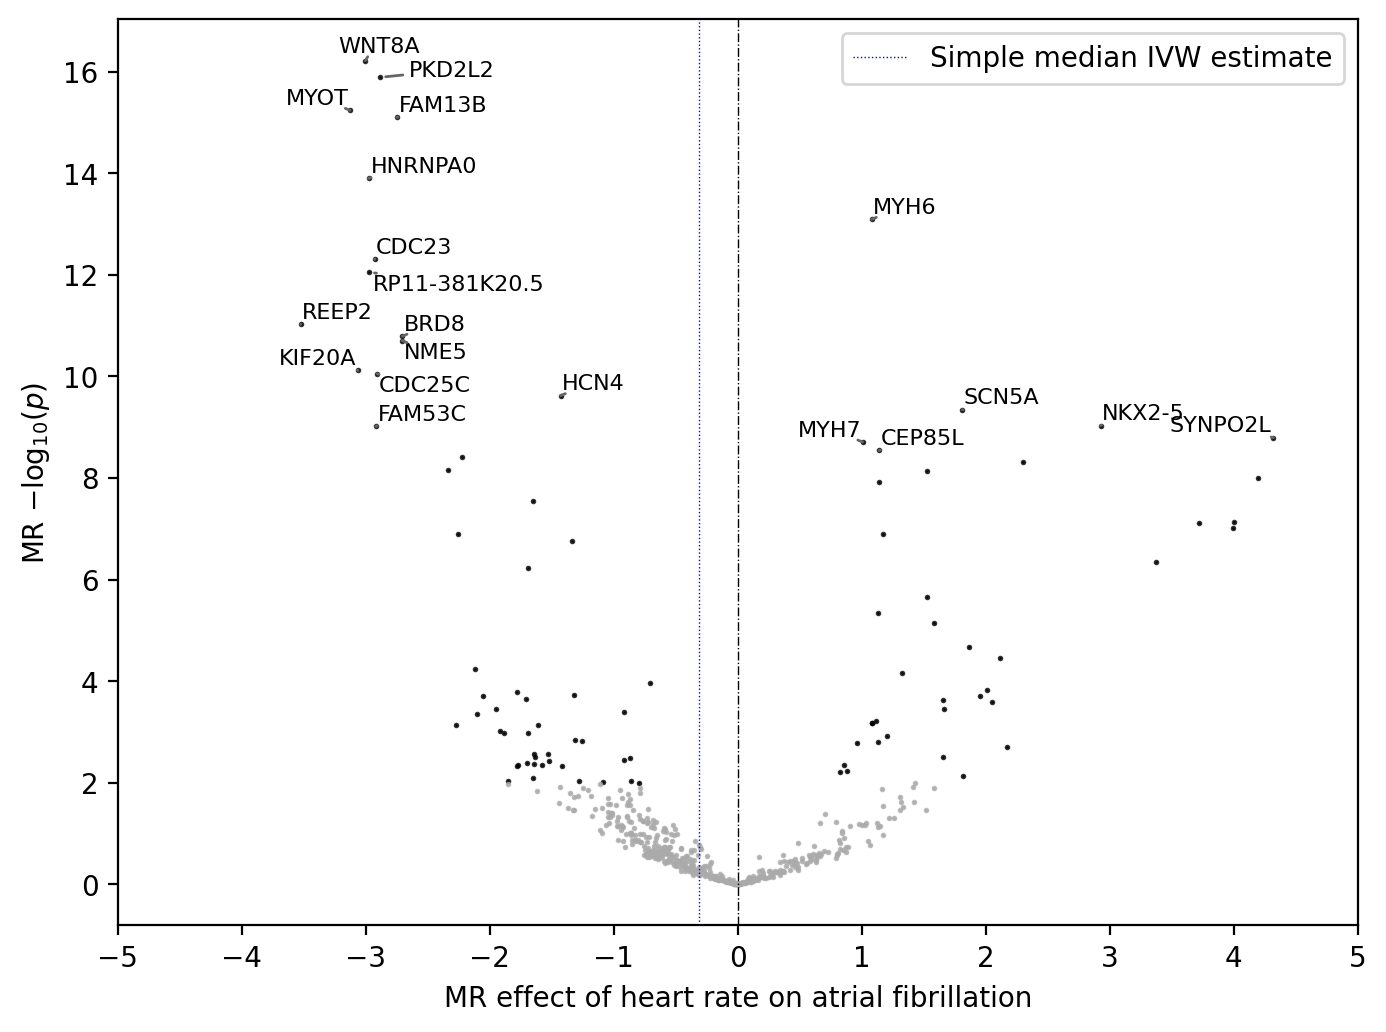

In [91]:
fig = plt.figure(figsize=(8, 6))
for sig, color in [(True, 'black'), (False, '#aaaaaa')]:
    if sig:
        pred = lambda o: o["wald_p"] <= 0.01
    else:
        pred = lambda o: o["wald_p"] > 0.01
    
    plt.scatter(
        [o["ivw_beta"] for o in mr_results if pred(o)],
        [o["wald_nlog10p"] for o in mr_results if pred(o)],
        
        s=1,
        color=color,
        alpha=0.8
    )
    
texts = []
for o in points_to_label:
    # Get gene name.
    ensembl_id = o["gene"]
    req = requests.get(f"https://exphewas.ca/v1/api/gene/ensembl/{ensembl_id}")
    res = req.json()
    gene_name = res.get("name", ensembl_id)
    
    text = plt.annotate(gene_name, (o["ivw_beta"], o["wald_nlog10p"]),
                        fontsize=8)
    
    texts.append(text)
    
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#666666'))

plt.xlabel("MR effect of heart rate on atrial fibrillation")
plt.ylabel(r"MR $-\log_{10}(p)$")
plt.xticks(np.arange(-5, 5 + 1))
plt.axvline(x=0, linestyle="-.", linewidth=0.5, color="black")
plt.axvline(x=np.median([o["ivw_beta"] for o in mr_results]),
            linestyle=":", linewidth=0.5, color="blue",
            label="Simple median IVW estimate")

plt.legend()

plt.savefig("demo-cisMR_heart_rate_afib.svg")